In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import project_path

In [11]:
import random

import numpy as np
import optuna
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from src.classifier import PostClassifier
from src.data_utils import load_data
from src.paths import datap, modelp
from src.training import Trainer

# Reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [4]:
loaded_study = optuna.load_study(study_name="ea_embeddings_classifier:2023-03-06", storage="sqlite:////home/justy/workspace/ea/ea-forum-announcements/src/db.sqlite3")
loaded_study

In [5]:
loaded_study.best_trial.params

{'batch_size': 32, 'lr': 0.09930735198146137}

In [6]:
dataset_size = len(pd.read_csv(datap("labeled_posts_embedded.csv")))
trainer = Trainer(epochs=9)

lr, batch_size = loaded_study.best_trial.params["lr"], loaded_study.best_trial.params["batch_size"]
train_dataset = test_dataset = load_data()

train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [0.6, 0.4])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
train_metrics, test_metrics = trainer.train(lr, train_loader, test_loader, logging=True)


Epoch 1
-------------------------------
train FPR 0.341 | train recall 0.323
test FPR 0.238 | test recall 0.469

Epoch 2
-------------------------------
train FPR 0.134 | train recall 0.684
test FPR 0.121 | test recall 0.682

Epoch 3
-------------------------------
train FPR 0.070 | train recall 0.801
test FPR 0.155 | test recall 0.612

Epoch 4
-------------------------------
train FPR 0.103 | train recall 0.760
test FPR 0.149 | test recall 0.599

Epoch 5
-------------------------------
train FPR 0.049 | train recall 0.886
test FPR 0.136 | test recall 0.609

Epoch 6
-------------------------------
train FPR 0.018 | train recall 0.967
test FPR 0.136 | test recall 0.609

Epoch 7
-------------------------------
train FPR 0.018 | train recall 0.967
test FPR 0.159 | test recall 0.571

Epoch 8
-------------------------------
train FPR 0.018 | train recall 0.967
test FPR 0.146 | test recall 0.584

Epoch 9
-------------------------------
train FPR 0.000 | train recall 1.000
test FPR 0.136 | t

In [20]:
test_dataset.indices

[18,
 98,
 135,
 237,
 183,
 130,
 85,
 214,
 200,
 187,
 301,
 15,
 103,
 13,
 211,
 298,
 34,
 2,
 249,
 289,
 29,
 137,
 87,
 49,
 198,
 164,
 151,
 63,
 168,
 217,
 162,
 221,
 190,
 254,
 41,
 53,
 245,
 100,
 22,
 285,
 101,
 152,
 208,
 140,
 55,
 189,
 62,
 23,
 26,
 174,
 17,
 266,
 128,
 236,
 268,
 278,
 295,
 311,
 116,
 263,
 117,
 145,
 199,
 288,
 46,
 155,
 51,
 134,
 172,
 283,
 229,
 252,
 235,
 154,
 227,
 191,
 92,
 16,
 210,
 9,
 70,
 195,
 286,
 224,
 267,
 150,
 77,
 185,
 265,
 4,
 270,
 276,
 281,
 157,
 114,
 35,
 147,
 122,
 113,
 79,
 175,
 204,
 131,
 158,
 106,
 40,
 127,
 80,
 108,
 56,
 124,
 222,
 38,
 119,
 163,
 279,
 42,
 269,
 307,
 299,
 102,
 274,
 165,
 11]

In [8]:
test_embeddings, test_labels, test_ids = test_dataset.dataset[test_dataset.indices]
test_preds = trainer.model(test_embeddings)
test_preds = torch.argmax(torch.nn.functional.softmax(test_preds, dim=1), dim=1)

In [9]:
conf_mat = confusion_matrix(test_labels, test_preds)

In [10]:
conf_mat.sum()

124

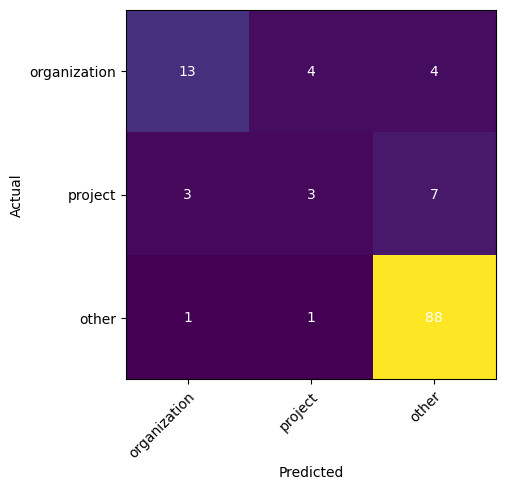

In [11]:
classes = ["organization", "project", "other"]

fig, ax = plt.subplots()
im = ax.imshow(conf_mat)

ax.set_xticks(np.arange(len(classes)), labels=classes)
ax.set_yticks(np.arange(len(classes)), labels=classes)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="w")

In [12]:
FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP+FN)
# Fall out or false positive rate
FPR = FP / (FP+TN)
TPR, FPR

(array([0.61904762, 0.23076923, 0.97777778]),
 array([0.03883495, 0.04504505, 0.32352941]))

In [13]:
np.mean(TPR), np.mean(FPR)

(0.6091982091982092, 0.13580313608868722)

In [97]:
### Find organizations that were classified as others

In [14]:
label_map = {"organization": 0, "project": 1, "other": 2}
class_map = {id_: class_ for class_, id_ in label_map.items()}

In [15]:
results = pd.DataFrame({"labels": test_labels, 
                        "preds": test_preds, 
                        "ids": test_ids})
results["pred_class"] = results.preds.map(class_map)
results["true_class"] = results.labels.map(class_map)

In [7]:
import pandas as pd

In [12]:
dataset = pd.read_csv(datap("labeled_posts.csv"))

In [13]:
dataset.head()

,_id,body,label
0,W5taETbarXR9CQnEQ,\n\nOur programs exist to have a positive impa...,2.0
1,H8RrdDHGBLQHHopMj,\n\n## The most important century is the one w...,2.0
2,toDKgyu3HdzKyQHPb,\n\nMeet us at the Karbach Biergarten for an I...,2.0
3,Nb2HnrqG4nkjCqmRg,"\n\nDisclaimer: We (Sam Nolan, Hannah Rokebran...",2.0
4,ZJpPvxXdimPgxFp2j,"\n\nAt Founders Pledge, we just launched a new...",0.0


In [19]:
print(dataset[dataset._id.str.startswith("QpG")]["body"].values[0])



High Impact Medicine, Hi-Med, is a new movement supported by CEA aiming to bring together medical students and  doctors into local groups to learn more about the ways medics can help as many people as possible in their careers, and engage with opportunities to have a wide-reaching positive impact within medicine. 

We believe medical students and doctors have the potential to effectively tackle some of the world’s leading problems alongside, and learning from, clinical practice. Medics are a demographic of individuals who are a natural fit for EA ideas and it is a career which grants flexibility and capital to contribute meaningfully to various areas. 

Our goal is to explore the core opportunities and challenges facing the world today, using an effective altruism framework, and use this as a springboard for discussion about the unique and potentially highly impactful role that medical students and doctors might play in this.

This year we are setting up local groups in Cambridge, Lo

### Organizations that were classified as projects
All of them had a word "organization" in the first paragraph come on

### Organizations that were classified as other
one fixed to other, the rest are really orgs

### Projects that were classified as other - what is actually a project?
relabeled some to other, the rest are actual projects

In [24]:
proj2other = results[(results.pred_class == "other") & (results.true_class == "project")]
proj2other

,labels,preds,ids,pred_class,true_class
116,1,2,DDsTgC59MER7cPiRh,other,project
172,1,2,LLAffXYqtYdWJ4fwr,other,project
195,1,2,Mts84Mv5cFHRYBBA8,other,project
175,1,2,6kFcr6L2jZhcsZnao,other,project
40,1,2,TfPdb2aMKzgWXFvc3,other,project
56,1,2,TT3gNbA534C7HNBCF,other,project
274,1,2,ohrmN8Y6LKJii8qA7,other,project


In [29]:
for idx in range(len(proj2other)):
    print(idx)
    print(dataset[dataset._id.isin(proj2other.ids)].iloc[idx]["_id"])
    print(dataset[dataset._id.isin(proj2other.ids)]["body"].values[idx])
    print("\n\n\n")
    print("=================================================================")

0
DDsTgC59MER7cPiRh


We are pleased to introduce Cause Innovation Bootcamp (CIB), a project that aims to train researchers interested in EA, while vetting new potential cause areas in Global Health and Development. We achieve this by taking research fellows through a training bootcamp that upskills them on the basics of evidence-based research and then getting them to produce a shallow report (using a standardised template) of a cause area, all whilst being supported by a senior mentor. These reports will then be posted on the EA Forum, and be sent to relevant organisations who the research might be of particular interest to, and for whom it might inform their decision-making. Cause areas are selected through a rough prioritisation which helps us identify which ones we think are most likely to be promising. We are currently running a pilot program for 5-6 fellows (7th Nov. 2022- 20th Dec. 2022).  Applications are open until 30th Oct. 2022 (Sunday)- please apply on the following applic

### Projects that were classified as organizations and may be they truly are?

In [21]:
proj2org = results[(results.pred_class == "organization") & (results.true_class == "project")]

In [23]:
idx = 0
print(dataset[dataset._id.isin(proj2org.ids)].iloc[idx]["_id"])
print(dataset[dataset._id.isin(proj2org.ids)]["body"].values[idx])
# print("\nJusty comments:\nThis seems like an organization")

AFgvA9imsT6bww8E3


# Key points 

  * Rethink Priorities (RP) has launched a Special Projects (SP) Program to help start promising EA initiatives by providing fiscal sponsorship and full-service operational support–including, but not limited to hiring, finance, event planning, and communications. 
  * A key strength of RP is its operations. We have been able to scale the organization from 1.5 full-time equivalents (FTE) staff to nearly 50 FTE in just four years.
  * The SP Program advances projects that RP would like to see happen and allows these projects to focus on their core work rather than worrying about running their organization.
  * Current special projects include Epoch, the Insect Welfare Project, Unjournal, EA Market Testing, Condor Camp, and EA Pathfinder.
  * There are various ways to get involved in the SP Program: join our team, apply to have your project sponsored, or share with us lessons you’ve learned incubating projects if you have experience in this arena. Please

In [18]:
idx = 1
print(dataset[dataset._id.isin(proj2org.ids)].iloc[idx]["_id"])
print(dataset[dataset._id.isin(proj2org.ids)]["body"].values[idx])
print("\nJusty comments:\nThis seems like an organization")

67awq5ozeYSjsYchk


We’ve had effective COVID vaccines for more than a year, but there are still countries where less than 10% of people have received a dose. Omicron has been spreading for almost three months, but pharma companies have only just started testing variant-specific shots. mRNA vaccines are highly effective, but they’re hard to manufacture and nearly impossible to distribute in parts of the developing world.

We won’t be ready for the next variant, or the next pandemic, until these problems are solved. 

An ideal vaccine platform for pandemic preparedness would be fast, effective, cheap, robust, and scalable enough to reach a critical portion of the global population as soon as any new pathogen is identified. Ideas have been floating around the EA biosecurity community for years about what such a platform would look like, and what it would take to build it, but there hasn’t been much direct work in the space.

The most recent COVID wave convinced a few of us that it was ti

In [19]:
idx = 2
print(dataset[dataset._id.isin(proj2org.ids)].iloc[idx]["_id"])
print(dataset[dataset._id.isin(proj2org.ids)]["body"].values[idx])
print("\nJusty comments:\nThis seems like an organization too, except they call it a project")

vxwcxwiDKCnyHJhbz


Hi all,

Here’s announcing a new project that Laura Pomarius and I have been working on, set to become its own organisation in 2019. Right now we’re primarily looking for (i) startup funding and (ii) promising graduate students in the humanities and social sciences (especially economics and philosophy) to join the new global priorities fellowship. Any questions, please ask below, or contact <laura.pomarius@centreforeffectivealtruism.org>.

# Summary

    * The Forethought Foundation for Global Priorities Research is a project incubated by the Centre for Effective Altruism. (In 2019, we aim to set up as an independent UK charity.)
    * Its main mission is to complement the Global Priorities Institute by promoting academic work that addresses the question of how to use our resources to improve the world by as much as possible. We are especially interested in issues relating to the claim that positively influencing the very long-term future should be altruists’ primar